# Charging Station Analysis Using Machine Learning

## Introduction

In this notebook, we will analyze a dataset containing information about charging stations. Our goal is to apply various machine learning techniques to predict whether a charging station is operational, estimate the cost associated with using a charging station, and identify the most important features influencing these predictions.

### Objectives:
1. **Classification Task**: Predict if a charging station is operational.
2. **Regression Task**: Predict the cost of charging based on station attributes.
3. **Feature Importance Analysis**: Determine which features are most influential in predicting outcomes.

## Data Preprocessing

Before we proceed with the machine learning tasks, we need to preprocess our dataset to handle missing values, encode categorical variables, and ensure all data is in a suitable format for modeling.

### Importing Libraries and Loading Data



In [ ]:
!pip install shap


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap

# Load dataset
df = pd.read_csv('Charging_Stations_2024T2_Cleaned___8.csv')

# Display the first few rows of the dataframe to understand its structure
df.head()

,cost,NumberOfPoints,UsageType.IsPayAtLocation,UsageType.IsMembershipRequired,UsageType.IsAccessKeyRequired,StatusType.IsOperational,latitude,longitude,operator,ConnectionType,Power,CurrentType
0,0.25,1.0,NaN,NaN,NaN,NaN,-41.049877,145.907330,Electric Highway Tasmania,"Type 2 (Socket Only), CHAdeMO",NaN,NaN
1,0.45,2.0,NaN,NaN,NaN,NaN,-33.079215,115.896802,Chargefox,"Type 1 (J1772), Type 2 (Socket Only), CHAdeMO",NaN,NaN
2,0.68,2.0,NaN,NaN,NaN,NaN,-32.797596,134.198964,Chargefox,NaN,NaN,NaN
3,0.68,4.0,False,True,True,True,-25.286042,152.815804,Evie,CCS (Type 2),150.0,DC
4,0.70,2.0,True,False,False,True,-26.199376,152.657057,(Unknown Operator),CCS (Type 2),160.0,DC


## Data Cleaning and Imputation

We have several columns with missing values. We will impute missing values for the UsageType columns using the most frequent value, as these columns have a significant number of missing entries. For other columns with missing values, we will drop the rows.

In [ ]:
# Convert 'cost' column to numeric
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

# Impute missing values only for UsageType columns
usage_type_columns = ['UsageType.IsPayAtLocation', 'UsageType.IsMembershipRequired', 'UsageType.IsAccessKeyRequired']
imputer = SimpleImputer(strategy='most_frequent')
df[usage_type_columns] = imputer.fit_transform(df[usage_type_columns])

# Drop rows with missing values in other columns
df = df.dropna()

# Display the dataframe after cleaning
df.head()

,cost,NumberOfPoints,UsageType.IsPayAtLocation,UsageType.IsMembershipRequired,UsageType.IsAccessKeyRequired,StatusType.IsOperational,latitude,longitude,operator,ConnectionType,Power,CurrentType
3,0.68,4.0,False,True,True,True,-25.286042,152.815804,Evie,CCS (Type 2),150.0,DC
4,0.70,2.0,True,False,False,True,-26.199376,152.657057,(Unknown Operator),CCS (Type 2),160.0,DC
6,0.69,12.0,False,True,True,True,-36.079284,146.913601,Tesla (including non-tesla),CCS (Type 2),250.0,DC
7,0.69,6.0,False,True,True,True,-35.131047,147.339787,Tesla (including non-tesla),CCS (Type 2),250.0,DC
8,0.55,1.0,False,True,True,True,-38.110287,145.264071,BP Pulse (AU),CCS (Type 2),75.0,DC


## Encoding Categorical Variables

To use categorical variables in our machine learning models, we need to convert them to numerical formats using one-hot encoding.

In [ ]:
# Convert categorical variables to numerical using one-hot encoding
categorical_features = ['UsageType.IsPayAtLocation', 'UsageType.IsMembershipRequired', 'UsageType.IsAccessKeyRequired',
                        'StatusType.IsOperational', 'operator', 'ConnectionType', 'CurrentType']
df = pd.get_dummies(df, columns=categorical_features)

# Display the dataframe after encoding
df.head()


,cost,NumberOfPoints,latitude,longitude,Power,UsageType.IsPayAtLocation_False,UsageType.IsPayAtLocation_True,UsageType.IsMembershipRequired_False,UsageType.IsMembershipRequired_True,UsageType.IsAccessKeyRequired_False,...,ConnectionType_Tesla (Model S/X),ConnectionType_Three Phase 5-Pin (AS/NZ 3123),ConnectionType_Type 1 (J1772),ConnectionType_Type 2 (Socket Only),ConnectionType_Type 2 (Tethered Connector),ConnectionType_Type I (AS 3112),ConnectionType_Unknown,CurrentType_AC (Single-Phase),CurrentType_AC (Three-Phase),CurrentType_DC
3,0.68,4.0,-25.286042,152.815804,150.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,0.70,2.0,-26.199376,152.657057,160.0,False,True,True,False,True,...,False,False,False,False,False,False,False,False,False,True
6,0.69,12.0,-36.079284,146.913601,250.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
7,0.69,6.0,-35.131047,147.339787,250.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
8,0.55,1.0,-38.110287,145.264071,75.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


## 1. Classification Task: Predicting If a Charging Station is Operational
### Objective

We aim to predict whether a charging station is operational (StatusType.IsOperational) based on various features such as cost, number of points, power, and other attributes.

### Approach

We will use a Random Forest Classifier, a robust ensemble learning method suitable for both classification and regression tasks. It operates by constructing multiple decision trees during training and outputting the mode of the classes for classification.

In [ ]:
# Select features and target for classification
classification_features = ['cost', 'NumberOfPoints', 'Power', 'latitude', 'longitude'] + \
                          [col for col in df.columns if any(feature in col for feature in usage_type_columns)]
X_class = df[classification_features]
y_class = df['StatusType.IsOperational_True']  # Assuming 'True' indicates operational

# Split data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_class, y_train_class)

# Predictions and evaluation for classification
y_pred_class = clf.predict(X_test_class)
print("Classification Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))

Classification Confusion Matrix:
 [[  0   5]
 [  0 215]]

Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00         5
        True       0.98      1.00      0.99       215

    accuracy                           0.98       220
   macro avg       0.49      0.50      0.49       220
weighted avg       0.96      0.98      0.97       220



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class Imbalance: The confusion matrix and classification report suggest a significant class imbalance in the dataset. With 215 instances labeled as 'True' and only 5 as 'False', the model learned to always predict 'True' to maximize accuracy. This is why the model has high accuracy but completely fails to identify any 'False' instances.

Impact of Imbalanced Data: The model's inability to predict the 'False' class results in undefined metrics (precision, recall, F1-score) for this class. The warning messages indicate this problem, and it stems from having no predicted samples for the 'False' class.

## 2. Regression Task: Predicting Charging Costs
### Objective

Our goal is to predict the cost (cost) of using a charging station based on various attributes such as power output, number of points, and usage types.

### Approach

We will use a Random Forest Regressor, an ensemble learning method that averages multiple decision trees to improve predictive accuracy and control overfitting.

In [ ]:
# Select features and target for regression
regression_features = ['NumberOfPoints', 'Power', 'latitude', 'longitude'] + \
                      [col for col in df.columns if 'UsageType' in col]
X_reg = df[regression_features]
y_reg = df['cost']

# Split data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

# Initialize and train the regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Predictions and evaluation for regression
y_pred_reg = regressor.predict(X_test_reg)
print("Regression Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))
print("Regression R^2 Score:", r2_score(y_test_reg, y_pred_reg))

Regression Mean Squared Error: 96.46684671000003
Regression R^2 Score: 0.4188378683178283


## 3. Feature Importance Analysis
### Objective

Understanding which features are most influential in our models helps us interpret their predictions and provides insights into the key drivers of operational status and cost.

### Approach

We will use feature importance scores from our Random Forest models and SHAP (SHapley Additive exPlanations) values to understand the impact of each feature on the model predictions.

### Feature Importance from Random Forest

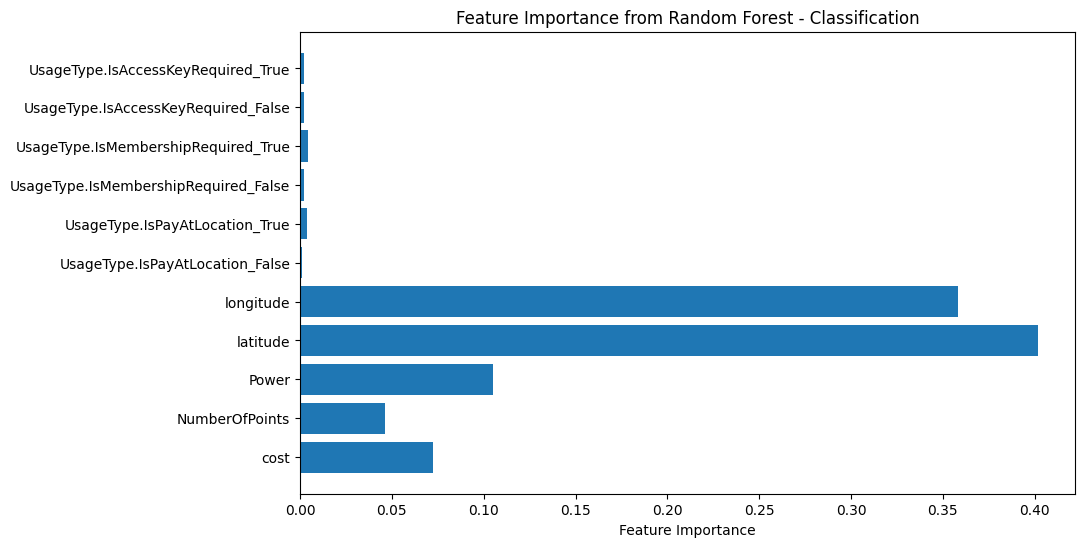

In [ ]:
# Feature importance from Random Forest for classification
feature_importances = clf.feature_importances_
feature_names = X_class.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest - Classification')
plt.show()

### SHAP Values for Regression

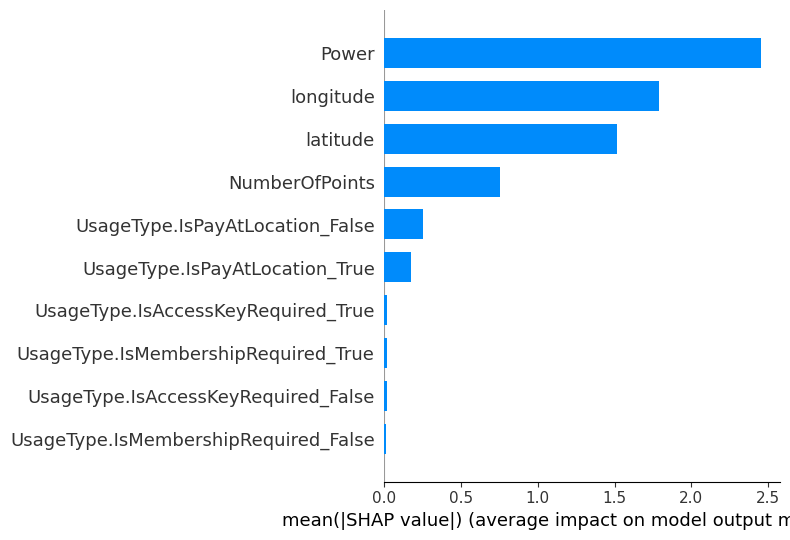

In [ ]:
# SHAP values for regression
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_reg)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_reg, plot_type="bar")

**Feature Importance from Random Forest (Classification):**

**Top Features:**

Latitude and Longitude: Geographical location seems to be the most significant factor in determining whether a station is operational. This could suggest regional differences in service levels or operational criteria.

Power: The power capacity of the station is another important feature, indicating that higher or lower power outputs may correlate with operational status.

Other Features: Features like NumberOfPoints and cost have lower importance, which might mean they are less directly related to the operational status.

**SHAP Values for Regression:**

**Top Features:**

Power: This is the most significant feature affecting the cost prediction, suggesting a strong relationship between charging power and cost.

Longitude and Latitude: Location continues to play an important role in determining cost, possibly due to regional pricing strategies.

Number of Points: Although less significant than power, it still has a noticeable impact, indicating that the number of charging points might influence the cost.

# Improving Charging Station Analysis Models

## Introduction

In this notebook, we will enhance our previous machine learning models by addressing identified issues and improving their predictive capabilities. The primary focus will be on handling class imbalance for the classification task, optimizing features and model parameters, and exploring additional data engineering techniques for both classification and regression tasks.

### Objectives:
1. **Improve Classification Task**: Address class imbalance and enhance model performance for predicting if a charging station is operational.
2. **Optimize Regression Task**: Refine the model predicting charging costs to increase accuracy.
3. **Advanced Feature Engineering**: Extract more insightful features from the dataset to boost model performance.

## 1. Handling Class Imbalance for Classification

### Problem

The initial classification model suffers from severe class imbalance, where most data points belong to one class (`True`), causing the model to predict this class exclusively.

### Solution

We will implement strategies to handle class imbalance:
1. **Resampling Techniques**: Use SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution.
2. **Evaluation Metrics**: Utilize more suitable metrics like F1-score and AUC-ROC to evaluate model performance on imbalanced data.

### Step-by-Step Implementation

#### 1.1 Install and Import Necessary Libraries



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)



### Handling Imbalance with SMOTE
SMOTE will synthetically create new instances for the minority class (False).

In [ ]:
# Select features and target for classification
classification_features = ['cost', 'NumberOfPoints', 'Power', 'latitude', 'longitude'] + \
                          [col for col in df.columns if any(feature in col for feature in usage_type_columns)]
X_class = df[classification_features]
y_class = df['StatusType.IsOperational_True']  # Assuming 'True' indicates operational

# Stratified split to maintain class distribution
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

# Resampling using SMOTE with Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_class_resampled, y_train_class_resampled = smote_tomek.fit_resample(X_train_class, y_train_class)

# Alternative Resampling using ADASYN
adasyn = ADASYN(random_state=42)
X_train_class_adasyn, y_train_class_adasyn = adasyn.fit_resample(X_train_class, y_train_class)

# Train RandomForestClassifier with class weight adjustment on SMOTE with Tomek Links resampled data
clf_rf = RandomForestClassifier(n_estimators=100, class_weight={0: 10, 1: 1}, random_state=42)
clf_rf.fit(X_train_class_resampled, y_train_class_resampled)

# Predictions and evaluation for classification
y_pred_class_rf = clf_rf.predict(X_test_class)
print("RandomForest with Class Weight Adjustment - Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class_rf))
print("\nRandomForest with Class Weight Adjustment - Classification Report:\n", classification_report(y_test_class, y_pred_class_rf))

# ROC-AUC Score
y_pred_prob_rf = clf_rf.predict_proba(X_test_class)[:, 1]
roc_auc_rf = roc_auc_score(y_test_class, y_pred_prob_rf)
print("RandomForest with Class Weight Adjustment - ROC-AUC Score:", roc_auc_rf)

# Train XGBoost on ADASYN resampled data
clf_xgb = xgb.XGBClassifier(scale_pos_weight=len(y_train_class_adasyn) / sum(y_train_class_adasyn), random_state=42)
clf_xgb.fit(X_train_class_adasyn, y_train_class_adasyn)

# Predictions and evaluation for XGBoost
y_pred_class_xgb = clf_xgb.predict(X_test_class)
print("XGBoost - Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class_xgb))
print("\nXGBoost - Classification Report:\n", classification_report(y_test_class, y_pred_class_xgb))

# ROC-AUC Score for XGBoost
y_pred_prob_xgb = clf_xgb.predict_proba(X_test_class)[:, 1]
roc_auc_xgb = roc_auc_score(y_test_class, y_pred_prob_xgb)
print("XGBoost - ROC-AUC Score:", roc_auc_xgb)

# Train LightGBM on ADASYN resampled data
clf_lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
clf_lgbm.fit(X_train_class_adasyn, y_train_class_adasyn)

# Predictions and evaluation for LightGBM
y_pred_class_lgbm = clf_lgbm.predict(X_test_class)
print("LightGBM - Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class_lgbm))
print("\nLightGBM - Classification Report:\n", classification_report(y_test_class, y_pred_class_lgbm))

# ROC-AUC Score for LightGBM
y_pred_prob_lgbm = clf_lgbm.predict_proba(X_test_class)[:, 1]
roc_auc_lgbm = roc_auc_score(y_test_class, y_pred_prob_lgbm)
print("LightGBM - ROC-AUC Score:", roc_auc_lgbm)


RandomForest with Class Weight Adjustment - Confusion Matrix:
 [[  0   5]
 [  0 215]]

RandomForest with Class Weight Adjustment - Classification Report:
               precision    recall  f1-score   support

       False       0.00      0.00      0.00         5
        True       0.98      1.00      0.99       215

    accuracy                           0.98       220
   macro avg       0.49      0.50      0.49       220
weighted avg       0.96      0.98      0.97       220

RandomForest with Class Weight Adjustment - ROC-AUC Score: 0.6637209302325582
XGBoost - Confusion Matrix:
 [[  1   4]
 [  1 214]]

XGBoost - Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

       False       0.50      0.20      0.29         5
        True       0.98      1.00      0.99       215

    accuracy                           0.98       220
   macro avg       0.74      0.60      0.64       220
weighted avg       0.97      0.98      0.97       220

XGBoost - ROC-AUC Score: 0.6232558139534884
[LightGBM] [Info] Number of positive: 502, number of negative: 499
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 1001, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

**RandomForest with Class Weight Adjustment:**

Limitations: The model still fails to predict any 'False' instances correctly, indicating that simply adjusting class weights was not sufficient to handle the severe class imbalance effectively.

**XGBoost:**

Shows improved performance over RandomForest by correctly predicting some 'False' instances, leading to better precision, recall, and F1-score for the minority class.

Still has low recall for the 'False' class, meaning it misses many 'False' instances.

**LightGBM:**

Strengths: LightGBM achieves the highest ROC-AUC score and manages to predict 'False' instances slightly better than RandomForest.